# Анализ схожести научных текстов с помощью методов естественной обработки языка и машинного обучения
Береза Анастасия // Учебная группа о.ИЗДтс 23.2/Б3-22

## Установка зависимостей


In [ ]:
# При первом запуске раскомментировать строку ниже
# %pip install kagglehub pandas numpy scikit-learn joblib nltk pymorphy3 matplotlib python-docx pyarrow

In [ ]:
# %pip install torch torchvision --index-url https://download.pytorch.org/whl/cu130

## Импорт библиотек


In [ ]:
import torch.nn as nn
import torch
import shutil
import re
import random
import pymorphy3
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import joblib

from typing import Dict

from torch.utils.data import TensorDataset, DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer

from pathlib import Path

from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk import download

from itertools import tee

from collections import defaultdict
from collections import Counter

from docx import Document
from datetime import datetime
from tkinter import Tk
from tkinter.filedialog import askopenfilename


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Используемое устройство:", device)

Используемое устройство: cuda


In [6]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Для GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
    # Оотключение недетерминированных алгоритмов
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Seed fixed: {seed}")

## Загрузка датасета

In [ ]:
path = kagglehub.dataset_download("ergkerg/russian-scientific-articles")
print("Path to dataset files:", path)

# Копирование в папку проекта

destination_path = os.path.join(os.getcwd(), "russian-scientific-articles")
shutil.copytree(path, destination_path, dirs_exist_ok=True)

print("Файлы датасета перенесены в:", destination_path)

## Сбор датасета

In [ ]:
# Сбор датасета из txt-файлов

rows = []
for root in ["russian-scientific-articles/data_3_1", "russian-scientific-articles/data_3"]:
     for p in Path(root).rglob("*.txt"):
        rows.append({
              "category": p.parent.name,
              "file": str(p),
              "text": p.read_text(encoding="utf-8", errors="ignore")
        })

df = pd.DataFrame(rows)
df.shape


In [ ]:
# Сохранение в файле

data_dir = Path("data")
data_dir.mkdir(exist_ok=True)

df_path = data_dir / "df.parquet"
df.to_parquet(df_path)

## Загрузка собранного датасета. Анализ

In [21]:
# Загрузка из файла

df = pd.read_parquet("data/df.parquet")
df.head()

,category,file,text
0,1 Автоматика. Вычислительная техника,russian-scientific-articles\data_3_1\1 Автомат...,"﻿2011 Компьютерная оптика, том 35, № 2 \n\nАЛГ..."
1,1 Автоматика. Вычислительная техника,russian-scientific-articles\data_3_1\1 Автомат...,﻿Software & Systems no....
2,1 Автоматика. Вычислительная техника,russian-scientific-articles\data_3_1\1 Автомат...,﻿Выделение контуров на изображениях с помощью ...
3,1 Автоматика. Вычислительная техника,russian-scientific-articles\data_3_1\1 Автомат...,﻿Программные продукты и системы / Software & S...
4,1 Автоматика. Вычислительная техника,russian-scientific-articles\data_3_1\1 Автомат...,﻿Алгоритм поэтапного уточнения проективного пр...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478 entries, 0 to 2477
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2478 non-null   object
 1   file      2478 non-null   object
 2   text      2478 non-null   object
dtypes: object(3)
memory usage: 58.2+ KB


In [6]:
df.isnull().sum()

category    0
file        0
text        0
dtype: int64

In [7]:
df['text'].describe(include='all')

count                                                  2478
unique                                                 2461
top       ﻿Авиационная и ракетно-космическая техника \n\...
freq                                                      2
Name: text, dtype: object

In [8]:
df.drop_duplicates(['text',], inplace=True)
df['text'].describe(include='all')

count                                                  2461
unique                                                 2461
top       ﻿2011 Компьютерная оптика, том 35, № 2 \n\nАЛГ...
freq                                                      1
Name: text, dtype: object

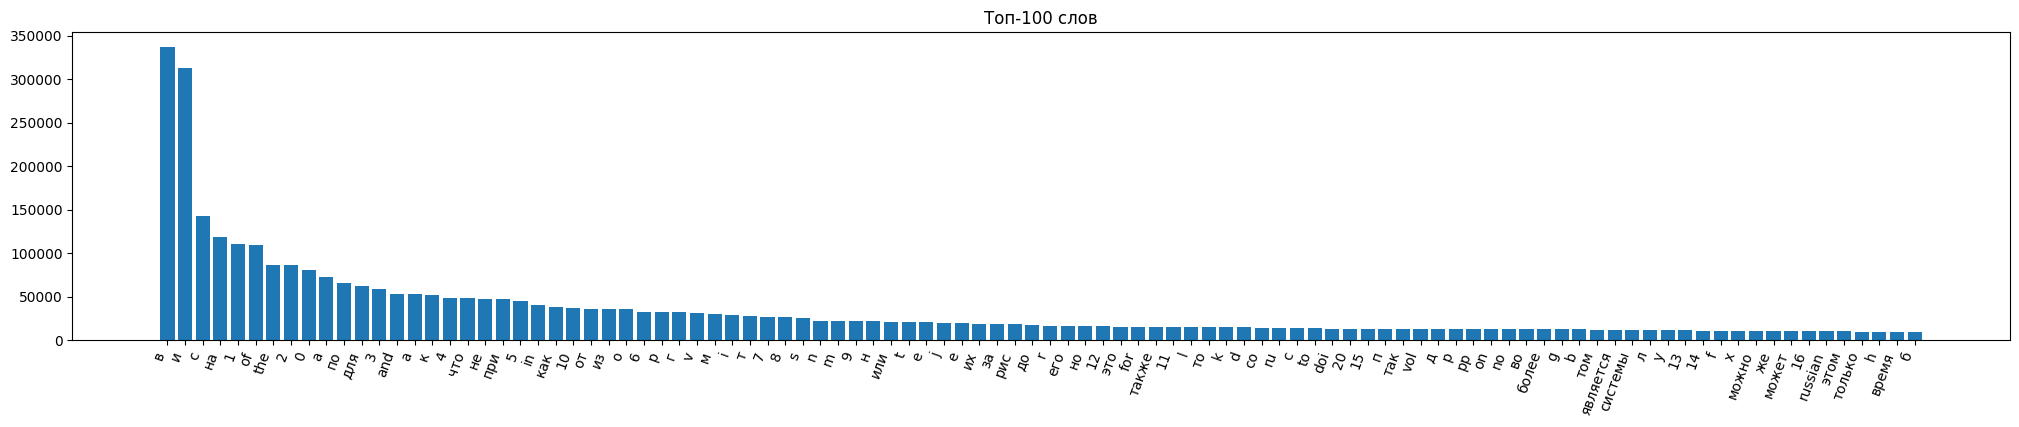

Топ-100 слов:

  1. в                    337259
  2. и                    313366
  3. с                    142198
  4. на                   118276
  5. 1                    110364
  6. of                   109351
  7. the                  86315
  8. 2                    85794
  9. 0                    81057
 10. а                    72737
 11. по                   65267
 12. для                  62789
 13. 3                    58386
 14. and                  52790
 15. a                    52605
 16. к                    52038
 17. 4                    48015
 18. что                  48008
 19. не                   47536
 20. при                  47140
 21. 5                    45442
 22. in                   40814
 23. как                  37713
 24. 10                   37248
 25. от                   36004
 26. из                   35948
 27. о                    35855
 28. 6                    32530
 29. p                    32272
 30. г                    31975
 31. v             

In [9]:
# Извлечение слов из всех статей

def raw_tokens(text):
    return re.findall(r"\w+", str(text).lower())

tokens = []
for article in df["text"].dropna():
    tokens.extend(raw_tokens(article))

# Гистограмма для топ-100 слов

top_n = 100
freq = Counter(tokens).most_common(top_n)
words, counts = zip(*freq)

plt.figure(figsize=(25,4))
plt.bar(words, counts)
plt.xticks(rotation=70, ha="right")
plt.title("Топ-100 слов")
plt.show()

print("Топ-100 слов:\n")
for i, (w, c) in enumerate(zip(words, counts), start=1):
    print(f"{i:3}. {w:<20} {c}")

# Топ пар из 2 слов 

def bigrams(seq):
    a, b = tee(seq)
    next(b, None)
    return zip(a, b)

bigram_freq = Counter(bigrams(tokens)).most_common(50)
print("\nТоп 50-биграмм")
for (w1, w2), c in bigram_freq:
    print(f"{w1} {w2}: {c}")

## Очистка текста

In [23]:
# Стоп-слова

download("stopwords", quiet=True)
stop_ru = set(stopwords.words("russian"))
stop_en = set(stopwords.words("english"))
custom_stop = {
    # указатели, ссылки
    "doi","org","orcid","http","https","url","удк", 
    # предлоги
    "в","и","с","на","по","для","что","как","от","из","при","но","же","у","о","к",
    # предлоги на англ
    "the","of","in","on","and","a","to","for","is","are",
    # одиночные буквы
    "к","р","п","г","т","е","а","м","н","л","у",
    # цифры
    "0","1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20"
}
custom_bigram_stop = {
    # служебные
    "и в","а также","при этом","а в","на основе","в том","и др","в качестве","так и","что в","не только",
    "но и", "таким образом","том что","том числе","в рамках","в результате","в россии","в виде","в этом",
    "с помощью","на рис",
    # пары чисел
    "1 1","1 2","1 0","2 1","2 2","2 3","2 0",
    "0 0","0 1","0 5","а а","в в","в а",
}
stop_all = stop_ru | stop_en | custom_stop | custom_bigram_stop

morph = pymorphy3.MorphAnalyzer()
english_stemmer = SnowballStemmer("english")

# Учитывать ли латиницу

keep_english = True
min_len = 3

# Сохранять кэш слов

lemma_cache: Dict[str, str] = {}
stem_cache: Dict[str, str] = {}

# Наборы шаблон-выражений

URL_RE = re.compile(r"https?://\S+|www\.\S+", re.IGNORECASE)
EMAIL_RE = re.compile(r"\b[\w.+-]+@[\w-]+\.[\w.-]+\b")
DOI_RE = re.compile(r"\b10\.\d{4,9}/[-._;()/:A-Za-z0-9]+\b", re.IGNORECASE)
ORCID_RE = re.compile(r"\b\d{4}-\d{4}-\d{4}-\d{3}[0-9X]\b")
NUMBER_RE = re.compile(r"\b\d[\d.,/%:-]*\d\b")
TOKEN_RE = re.compile(r"[A-Za-z\u0400-\u04FF]+")
CYRILLIC_RE = re.compile(r"[\u0400-\u04FF]")
LATIN_RE = re.compile(r"[A-Za-z]")

# Функция для очистки по шаблонам

def strip_noise(text: str) -> str:
    text = text.replace("\u00a0", " " ).replace("\ufeff", " " )
    text = URL_RE.sub(" " , text)
    text = EMAIL_RE.sub(" " , text)
    text = DOI_RE.sub(" " , text)
    text = ORCID_RE.sub(" " , text)
    text = NUMBER_RE.sub(" " , text)
    return text

# Функция предобработки текста 

def clean_text(raw: str) -> str:
    text = strip_noise(raw.lower())
    lemmas: list[str] = []
    for token in TOKEN_RE.findall(text):
        if len(token) < min_len:
            continue
        has_cyr = bool(CYRILLIC_RE.search(token))
        has_lat = bool(LATIN_RE.search(token))
        if has_cyr and has_lat:
            continue
        if has_cyr:
            lemma = lemma_cache.get(token)
            if lemma is None:
                lemma = morph.parse(token)[0].normal_form
                lemma_cache[token] = lemma
            if len(lemma) >= min_len and lemma not in stop_all:
                lemmas.append(lemma)
        elif has_lat and keep_english:
            stem = stem_cache.get(token)
            if stem is None:
                stem = english_stemmer.stem(token)
                stem_cache[token] = stem
            if len(stem) >= min_len and stem not in stop_all:
                lemmas.append(stem)
    return " ".join(lemmas)

In [ ]:
# Предобработка датасета с помощью функции 

clean_df = (
    df.assign(clean_text=df["text"].map(clean_text))
      .loc[lambda d: d["clean_text"] != ""]
      .reset_index(drop=True)
)

clean_df.head()


In [ ]:
clean_df.info()

In [ ]:
clean_df["clean_text"].tolist()

In [11]:
# Сохранение в файл очищенный набор данных
clean_df.to_json("cleaned_dataset.jsonl", orient="records", lines=True, force_ascii=False)

### Визуализация частоты использования очищенных слов

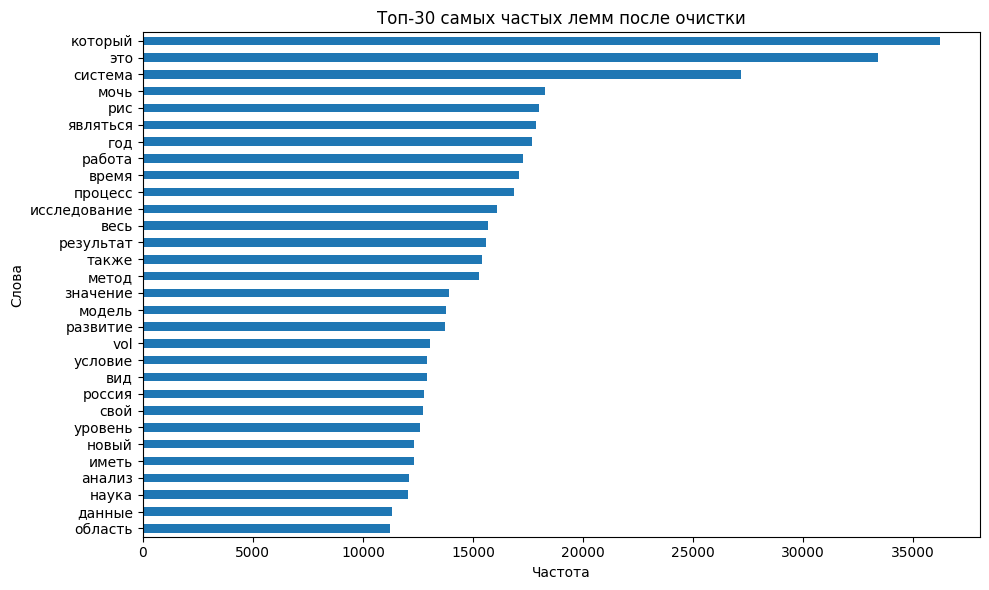

In [12]:
tokens = clean_df["clean_text"].str.split().explode()
freq = tokens.value_counts().head(30)

plt.figure(figsize=(10, 6))
freq.sort_values().plot(kind="barh")
plt.xlabel("Частота")
plt.ylabel("Слова")
plt.title("Топ-30 самых частых лемм после очистки")
plt.tight_layout()
plt.show()

C:\Users\Basss\AppData\Local\Temp\ipykernel_16200\3547756974.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


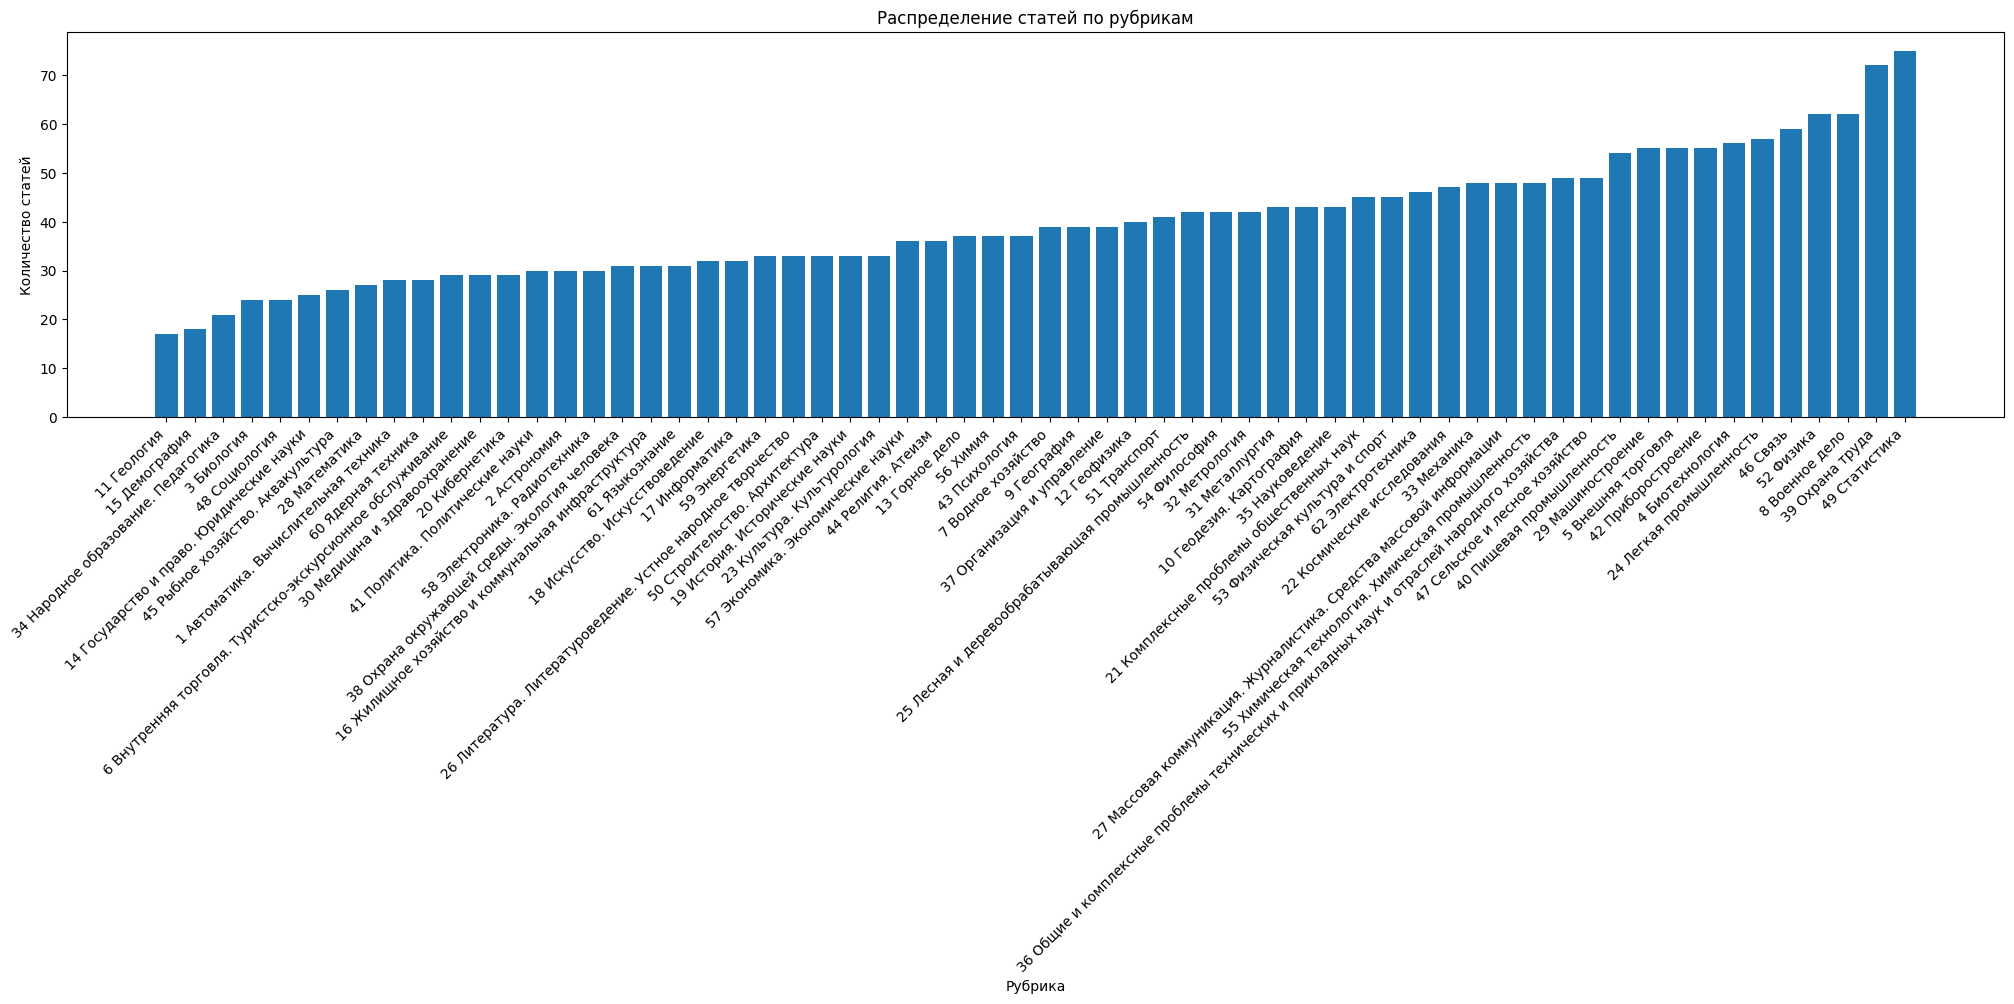

In [13]:
# Количество статей по рубрикам
category_counts = (clean_df["category"].value_counts().sort_values())

# Вывод столбчатой диаграммы
fig, ax = plt.subplots(figsize=(25, 5))
ax.bar(category_counts.index.astype(str), category_counts.values)
ax.set_xlabel("Рубрика")
ax.set_ylabel("Количество статей")
ax.set_title("Распределение статей по рубрикам")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# Обучение модели

## Подготовка

In [14]:
# Загрузка набора данных из файла
clean_df = pd.read_json("cleaned_dataset.jsonl", lines=True)
clean_df.head()

,category,file,text,clean_text
0,1 Автоматика. Вычислительная техника,russian-scientific-articles\data_3_1\1 Автомат...,"﻿2011 Компьютерная оптика, том 35, № 2 \n\nАЛГ...",компьютерный оптика алгоритм встраивание полух...
1,1 Автоматика. Вычислительная техника,russian-scientific-articles\data_3_1\1 Автомат...,﻿Software & Systems no....,softwar system программный продукт система дат...
2,1 Автоматика. Вычислительная техника,russian-scientific-articles\data_3_1\1 Автомат...,﻿Выделение контуров на изображениях с помощью ...,выделение контур изображение помощь алгоритм к...
3,1 Автоматика. Вычислительная техника,russian-scientific-articles\data_3_1\1 Автомат...,﻿Программные продукты и системы / Software & S...,программный продукт система softwar system дат...
4,1 Автоматика. Вычислительная техника,russian-scientific-articles\data_3_1\1 Автомат...,﻿Алгоритм поэтапного уточнения проективного пр...,алгоритм поэтапный уточнение проективный преоб...


In [ ]:
# Разделение на обучающую и валидационную выборку

train_df, test_df = train_test_split(clean_df, test_size=0.2, stratify=clean_df["category"], random_state = 42)

print("Размер train:", train_df.shape)
print("Размер test:", test_df.shape)

In [ ]:
# Векторизация TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), lowercase=False, min_df=2)

train_texts = train_df["clean_text"].tolist()
test_texts = test_df["clean_text"].tolist()

X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

y_train = train_df["category"].astype(str).to_numpy()
y_test = test_df["category"].astype(str).to_numpy()

print("Матрица X_train:", X_train.shape)
print("Матрица X_test:", X_test.shape)

# Сохранение векторизатора для будущего использования
joblib.dump(vectorizer, "tfidf_vectorizer.joblib")

In [ ]:
print("NNZ train:", X_train.nnz)
print("Среднее число ненулевых признаков на документ:",
      X_train.nnz / X_train.shape[0])

In [ ]:
# Функция создания пар текстов

def make_pairs(X, y, n_pos=3, n_neg=3, random_state= 42):
    rng = np.random.RandomState(random_state)
    y = np.asarray(y)

    label2idx = defaultdict(list)
    for idx, label in enumerate(y):
        label2idx[label].append(idx)

    all_index = np.arange(len(y))
    pair_i = []
    pair_j = []
    pair_labels = []

    for label, idxs in label2idx.items():
        idxs = np.asarray(idxs)
        other_index = np.setdiff1d(all_index, idxs)

        for i in idxs:
            # положительные пары (та же категория)
            if len(idxs) > 1:
                pos_candidates = idxs[idxs != i]
                n_sample_pos = min(n_pos, len(pos_candidates))
                pos = rng.choice(pos_candidates, size=n_sample_pos, replace=False)
                for j in pos:
                    pair_i.append(i)
                    pair_j.append(j)
                    pair_labels.append(1)

            # отрицательные пары (другая категория)
            if len(other_index) > 0:
                n_sample_neg = min(n_neg, len(other_index))
                neg = rng.choice(other_index, size=n_sample_neg, replace=False)
                for j in neg:
                    pair_i.append(i)
                    pair_j.append(j)
                    pair_labels.append(0)

    pair_i = np.asarray(pair_i)
    pair_j = np.asarray(pair_j)
    pair_labels = np.asarray(pair_labels, dtype=int)

    print(f"Сформировано пар: {len(pair_labels)} "
          f"(положительных: {(pair_labels == 1).sum()}, отрицательных: {(pair_labels == 0).sum()})")

    return pair_i, pair_j, pair_labels


# Формирование обучающих и тестовых пар
train_idx_i, train_idx_j, y_train_pairs = make_pairs(X_train, y_train, n_pos=3, n_neg=3, random_state=42)
test_idx_i, test_idx_j, y_test_pairs = make_pairs(X_test, y_test, n_pos=3, n_neg=3, random_state=42)


## Проектирование модели

### Модель CosineMLP
Принимает один признак - косинус между векторами пары текстов

In [ ]:
# Формирование данных в виде косинуса

def pair_cosine_features(X, idx_i, idx_j):
    idx_i = np.asarray(idx_i)
    idx_j = np.asarray(idx_j)
    sims = []
    for a, b in zip(idx_i, idx_j):
        Xi = X[a]
        Xj = X[b]
        sims.append([cosine_similarity(Xi, Xj)[0, 0]])
    return np.array(sims, dtype="float32")

# Генерация признаков для пар

X_train_pairs = pair_cosine_features(X_train, train_idx_i, train_idx_j)
X_test_pairs  = pair_cosine_features(X_test,  test_idx_i,  test_idx_j)

print("Форма X_train_pairs:", X_train_pairs.shape)
print("Форма X_test_pairs :", X_test_pairs.shape)


In [ ]:
# Тензоры и dataloader для модели

X_train_cos_t = torch.from_numpy(X_train_pairs)
y_train_cos_t = torch.from_numpy(y_train_pairs.astype("float32")).view(-1, 1)

X_test_cos_t  = torch.from_numpy(X_test_pairs)
y_test_cos_t  = torch.from_numpy(y_test_pairs.astype("float32")).view(-1, 1)

cos_train_ds = TensorDataset(X_train_cos_t, y_train_cos_t)
cos_test_ds  = TensorDataset(X_test_cos_t,  y_test_cos_t)

cos_batch_size = 512

cos_train_loader = DataLoader(cos_train_ds, batch_size=cos_batch_size, shuffle=True)
cos_test_loader  = DataLoader(cos_test_ds,  batch_size=cos_batch_size, shuffle=False)


### Определение архитектуры модели

In [8]:
class CosineMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.net(x)

### Функция обучения

In [ ]:
def train_cosine_model(train_loader, test_loader, device, num_epochs=10):
    model = CosineMLP().to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    history = {
        "train_loss": [],
        "test_loss": [],
        "test_acc": [],
        "test_auc": []
    }

    best_auc = -1.0
    best_state = None
    patience = 3
    no_improve = 0

    for epoch in range(1, num_epochs + 1):
        # Обучение
        model.train()
        train_loss = 0.0

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * xb.size(0)

        train_loss /= len(train_loader.dataset)

        # Тестирование
        model.eval()
        test_loss = 0.0
        all_logits = []
        all_targets = []

        with torch.no_grad():
            for xb, yb in test_loader:
                xb = xb.to(device)
                yb = yb.to(device)

                logits = model(xb)
                loss = criterion(logits, yb)
                test_loss += loss.item() * xb.size(0)

                all_logits.append(logits.cpu())
                all_targets.append(yb.cpu())

        test_loss /= len(test_loader.dataset)

        all_logits = torch.cat(all_logits, dim=0)
        all_targets = torch.cat(all_targets, dim=0)

        proba = torch.sigmoid(all_logits).numpy().reshape(-1)
        true  = all_targets.numpy().reshape(-1)
        pred  = (proba >= 0.5).astype("int32")

        acc = accuracy_score(true, pred)
        auc = roc_auc_score(true, proba)

        history["train_loss"].append(train_loss)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(acc)
        history["test_auc"].append(auc)

        print(f"CosineMLP: Эпоха {epoch}: "
              f"train_loss={train_loss:.4f}  test_loss={test_loss:.4f}  "
              f"Точность={acc:.4f}  AUC={auc:.4f}")

        # Early Stop
        if auc > best_auc:
            best_auc = auc
            best_state = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"AUC не улучшался {patience} эпох(и). Остановка обучения.")
                break

    # Загружаются веса с лучшей эпохи
    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history

# Выполнение
set_seed(42)

cos_model, hist_cos = train_cosine_model(cos_train_loader, cos_test_loader, device, num_epochs=10)


In [ ]:
epochs = range(1, len(hist_cos["train_loss"]) + 1)

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, hist_cos["train_loss"], label="train_loss")
plt.plot(epochs, hist_cos["test_loss"], label="test_loss")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.title("CosineMLP: Loss")
plt.legend()

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, hist_cos["test_acc"], label="test_acc")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.title("CosineMLP: Accuracy")

# AUC
plt.subplot(1, 3, 3)
plt.plot(epochs, hist_cos["test_auc"], label="test_auc")
plt.xlabel("Эпоха")
plt.ylabel("AUC")
plt.title("CosineMLP: AUC")

plt.tight_layout()
plt.show()


In [ ]:
# Сохранение модели

os.makedirs("models", exist_ok=True)

torch.save(cos_model.state_dict(), "models/cosine_mlp.pt")


### Модель PairMLP
Принимает два признака - векторы пары текстов

In [ ]:
# Формирование признаков: два вектора для каждой пары

def pair_vector_features(X, idx_i, idx_j):
    idx_i = np.asarray(idx_i)
    idx_j = np.asarray(idx_j)
    X1 = X[idx_i].toarray().astype("float32")
    X2 = X[idx_j].toarray().astype("float32")

    return X1, X2

# Генерация признаков для пар (train / test)

X_train_1, X_train_2 = pair_vector_features(X_train, train_idx_i, train_idx_j)
X_test_1, X_test_2 = pair_vector_features(X_test, test_idx_i, test_idx_j)

print("Форма X_train_1:", X_train_1.shape)
print("Форма X_train_2:", X_train_2.shape)
print("Форма X_test_1:", X_test_1.shape)
print("Форма X_test_2:", X_test_2.shape)


In [ ]:
class PairVectorDataset(Dataset):
    def __init__(self, X1, X2, y):
        self.X1 = torch.from_numpy(X1)
        self.X2 = torch.from_numpy(X2)
        self.y = torch.from_numpy(y.astype("float32")).view(-1, 1)

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.y[idx]


pair_batch_size = 512

train_pair_ds = PairVectorDataset(X_train_1, X_train_2, y_train_pairs)
test_pair_ds= PairVectorDataset(X_test_1,X_test_2,y_test_pairs)

train_pair_loader = DataLoader(train_pair_ds, batch_size=pair_batch_size, shuffle=True)
test_pair_loader = DataLoader(test_pair_ds, batch_size=pair_batch_size, shuffle=False)


### Определение архитектуры модели

In [14]:
class PairMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, dropout_p=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, x1, x2):
        x = torch.cat([x1, x2], dim=1)
        return self.net(x)

### Обучение

In [13]:
# Сколько входных признаков

input_dim = X_train.shape[1]
print("Размер TF-IDF признакового пространства:", input_dim)

NameError: name 'X_train' is not defined

In [ ]:
def train_pair_mlp(train_loader, test_loader, device, input_dim, num_epochs=10):
    model = PairMLP(input_dim=input_dim).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    history = {
        "train_loss": [],
        "test_loss": [],
        "test_acc": [],
        "test_auc": []
    }

    best_auc = -1.0
    best_state = None
    patience = 3
    no_improve = 0

    for epoch in range(1, num_epochs + 1):
        # Обучение
        model.train()
        total_train_loss = 0.0

        for xb1, xb2, yb in train_loader:
            xb1 = xb1.to(device)
            xb2 = xb2.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            logits = model(xb1, xb2)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * xb1.size(0)

        train_loss = total_train_loss / len(train_loader.dataset)

        # Тестирование
        model.eval()
        total_test_loss = 0.0
        all_logits = []
        all_targets = []

        with torch.no_grad():
            for xb1, xb2, yb in test_loader:
                xb1 = xb1.to(device)
                xb2 = xb2.to(device)
                yb = yb.to(device)

                logits = model(xb1, xb2)
                loss = criterion(logits, yb)
                total_test_loss += loss.item() * xb1.size(0)

                all_logits.append(logits.cpu())
                all_targets.append(yb.cpu())

        test_loss = total_test_loss / len(test_loader.dataset)

        all_logits = torch.cat(all_logits, dim=0)
        all_targets = torch.cat(all_targets, dim=0)

        proba = torch.sigmoid(all_logits).numpy().reshape(-1)
        true = all_targets.numpy().reshape(-1)
        pred = (proba >= 0.5).astype("int32")

        acc = accuracy_score(true, pred)
        auc = roc_auc_score(true, proba)

        history["train_loss"].append(train_loss)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(acc)
        history["test_auc"].append(auc)

        print(
            f"PairMLP: Эпоха {epoch}: "
            f"train_loss={train_loss:.4f} test_loss={test_loss:.4f} "
            f"Точность={acc:.4f} AUC={auc:.4f}"
        )

        # early stopping по AUC
        if auc > best_auc:
            best_auc = auc
            best_state = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"AUC не улучшался {patience} эпох(и). Остановка обучения.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history

set_seed(42)

input_dim = X_train.shape[1]

pair_model, hist_pair = train_pair_mlp(train_pair_loader, test_pair_loader, device, input_dim=input_dim, num_epochs=40)


In [ ]:
epochs = range(1, len(hist_pair["train_loss"]) + 1)

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, hist_pair["train_loss"], label="train_loss")
plt.plot(epochs, hist_pair["test_loss"], label="test_loss")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.title("PairMLP: Loss")
plt.legend()

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, hist_pair["test_acc"], label="test_acc")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.title("PairMLP: Accuracy")

# AUC
plt.subplot(1, 3, 3)
plt.plot(epochs, hist_pair["test_auc"], label="test_auc")
plt.xlabel("Эпоха")
plt.ylabel("AUC")
plt.title("PairMLP: AUC")

plt.tight_layout()
plt.show()


In [ ]:
os.makedirs("models", exist_ok=True)
torch.save(pair_model.state_dict(), "models/pair_mlp.pt")


# Тестирование

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Используемое устройство:", device)

# Загрузка TF-IDF векторизатора
vectorizer = joblib.load("tfidf_vectorizer.joblib")

# Определяем размерность TF-IDF-признаков
tfidf_dim = vectorizer.transform(["тестовая строка"]).shape[1]
print("Размерность TF-IDF:", tfidf_dim)

# Загрузка модели CosineMLP
cos_model = CosineMLP().to(device)
cos_model.load_state_dict(torch.load("models/cosine_mlp.pt", map_location=device))
cos_model.eval()

# Загрузка модели PairMLP

pair_model = PairMLP(input_dim=tfidf_dim).to(device)
pair_model.load_state_dict(torch.load("models/pair_mlp.pt", map_location=device))
pair_model.eval()

print("Модели загружены.")

Используемое устройство: cuda
Размерность TF-IDF: 5000
Модели загружены.


In [25]:
# Функция  подготовки пары текстов для CosineMLP

def prepare_tfidf_pair_cosine(text1: str, text2: str):
    clean1 = clean_text(text1)
    clean2 = clean_text(text2)

    # Проверка пустого текста
    if clean1.strip() == "" or clean2.strip() == "":
        print("Внимание: один из текстов после очистки оказался пустым.")
    
    X_pair = vectorizer.transform([clean1, clean2])
    x1 = X_pair[0]
    x2 = X_pair[1]
    return x1, x2, clean1, clean2

# Функция  подготовки пары текстов для PairMLP

def prepare_tfidf_pair_twovectors(text1: str, text2: str):
    clean1 = clean_text(text1)
    clean2 = clean_text(text2)

    if clean1.strip() == "" or clean2.strip() == "":
        print("Внимание: один из текстов после очистки оказался пустым.")
        
    X_pair = vectorizer.transform([clean1, clean2]).toarray().astype("float32")
    x1 = torch.from_numpy(X_pair[0:1]).to(device)
    x2 = torch.from_numpy(X_pair[1:1+1]).to(device)

    return x1, x2, clean1, clean2


In [26]:
# Использование cosineMLP для анализа текстов

def predict_with_cosine_mlp(text1: str, text2: str, threshold: float = 0.5):

    x1, x2, clean1, clean2 = prepare_tfidf_pair_cosine(text1, text2)

    # Косинусное сходство между TF-IDF векторами
    cos = float(cosine_similarity(x1, x2)[0, 0])

    # Преобразуем в тензор формы (1, 1)
    inp = torch.tensor([[cos]], dtype=torch.float32, device=device)

    cos_model.eval()
    with torch.no_grad():
        logit = cos_model(inp)
        prob = torch.sigmoid(logit).item()

    label = int(prob >= threshold)
    return prob, label, cos

# Использование pairMLP для анализа

def predict_with_pair_mlp(text1: str, text2: str, threshold: float = 0.5):
    x1_t, x2_t, clean1, clean2 = prepare_tfidf_pair_twovectors(text1, text2)

    pair_model.eval()
    with torch.no_grad():
        logit = pair_model(x1_t, x2_t)
        prob = torch.sigmoid(logit).item()

    label = int(prob >= threshold)
    return prob, label


In [ ]:
# Загрузка текста из пользовательского файла

def load_text_from_file(path: str) -> str:
    path = path.strip().strip('"').strip("'")
    ext = os.path.splitext(path)[1].lower()

    if not os.path.exists(path):
        raise FileNotFoundError(f"Файл не найден: {path}")

    # TXT
    if ext == ".txt":
        with open(path, "r", encoding="utf-8") as f:
            return f.read()

    # DOCX
    elif ext == ".docx":
        from docx import Document
        doc = Document(path)
        return "\n".join(p.text for p in doc.paragraphs)

    # PDF
    elif ext == ".pdf":
        import pdfplumber
        text = ""
        with pdfplumber.open(path) as pdf:
            for page in pdf.pages:
                extracted = page.extract_text()
                if extracted:
                    text += extracted + "\n"
        if not text.strip():
            raise ValueError("Не удалось извлечь текст из PDF")
        return text

    else:
        raise ValueError(
            f"Неподдерживаемый формат файла: {ext}. "
            f"Используй .txt, .docx или .pdf."
        )

def get_text(source_name: str):
    while True:
        mode = input(
            f"Как получить {source_name}? "
            f"(1 — ввести вручную, 2 — выбрать файл, команда esc - отмена): "
        ).strip()

        # Отмена
        if mode.lower() == "esc":
            print("Операция отменена пользователем.")
            return None, None

        # Ввод текста вручную
        if mode == "1":
            print(f"\nВведи {source_name}:")
            text = input()

            if text.lower() == "esc":
                print("Операция отменена.")
                return None, None

            preview = text.replace("\n", " ")[:1000]
            desc = f"ручной ввод (первые 1000 символов: \"{preview}\")"
            return text, desc

        # Выбор файла из проводника
        elif mode == "2":
            print("Откроется окно выбора файла...")

            from tkinter import Tk
            from tkinter.filedialog import askopenfilename

            Tk().withdraw()

            file_path = askopenfilename(
                title=f"Выбор файла для {source_name}",
                filetypes=[
                    ("Все файлы", "*.*")
                    ("Текстовые файлы", "*.txt"),
                    ("Документы Word", "*.docx"),
                    ("PDF файлы", "*.pdf")
                ]
            )

            if not file_path:
                print("Операция отменена.")
                return None, None

            try:
                text = load_text_from_file(file_path)
            except Exception as e:
                print(f"Ошибка при чтении файла: {e}")
                continue

            desc = f"файл: {file_path}"
            print(f"Файл выбран: {file_path}")
            return text, desc

        else:
            print("Некорректный выбор. Введите 1, 2 или команду esc.")

def save_comparison_report(text_a_source:str, text_b_source:str, prob_cos:float, label_cos:int, cos:float, prob_pair:float, label_pair:int, report_path:str = "reports/comparison_report.txt"):

    report_path = Path(report_path)
    report_path.parent.mkdir(parents=True, exist_ok=True)
    ts = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    with open(report_path, "a", encoding="utf-8") as f:
        f.write("=" * 80 + "\n")
        f.write(f"Время сравнения: {ts}\n")
        f.write(f"Источник текста A: {text_a_source}\n")
        f.write(f"Источник текста B: {text_b_source}\n\n")

        f.write("Модель CosineMLP\n")
        f.write(f"Косинусное сходство: {cos:.4f}\n")
        f.write(f"Вероятность схожести: {prob_cos:.4f}\n")
        f.write(
            "Решение: "
            + ("Похожие" if label_cos == 1 else "Не похожие")
            + "\n\n"
        )

        f.write("Модель PairMLP\n")
        f.write(f"Вероятность схожести: {prob_pair:.4f}\n")
        f.write(
            "Решение: "
            + ("Похожие" if label_pair == 1 else "Не похожие")
            + "\n\n"
        )

    print(f"\nРезультаты сравнения сохранены в отчёт: {report_path}")



<>:84: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
<>:84: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
C:\Users\Basss\AppData\Local\Temp\ipykernel_1452\3481092482.py:84: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  ("Все файлы", "*.*")


In [33]:
if __name__ == "__main__":
    # Первый текст
    text_a, src_a = get_text("первый текст")
    if text_a is None:
        print("Работа программы завершена.")
        exit()

    # Второй текст
    text_b, src_b = get_text("второй текст")
    if text_b is None:
        print("Работа программы завершена.")
        exit()

    # СosineMLP
    print("\nМодель CosineMLP")
    prob_cos, label_cos, cos = predict_with_cosine_mlp(text_a, text_b)
    print(f"Косинусное сходство: {cos:.4f}")
    print(f"Вероятность схожести: {prob_cos:.4f}")
    print("Решение:", "Похожие" if label_cos == 1 else "Не похожие")

    # PairMLP
    print("\nМодель PairMLP")
    prob_pair, label_pair = predict_with_pair_mlp(text_a, text_b)
    print(f"Вероятность схожести: {prob_pair:.4f}")
    print("Решение:", "Похожие" if label_pair == 1 else "Не похожие")

    # Отчёт
    save_comparison_report(
        text_a_source=src_a,
        text_b_source=src_b,
        prob_cos=prob_cos,
        label_cos=label_cos,
        cos=cos,
        prob_pair=prob_pair,
        label_pair=label_pair,
        report_path="reports/comparison_report.txt"
    )


Некорректный выбор. Введите 1, 2 или команду esc.

Введи первый текст:

Введи второй текст:

Модель CosineMLP
Косинусное сходство: 0.0000
Вероятность схожести: 0.4894
Решение: Не похожие

Модель PairMLP
Вероятность схожести: 0.1304
Решение: Не похожие

Результаты сравнения сохранены в отчёт: reports\comparison_report.txt
